In [313]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

In [314]:
train_df: DataFrame = pd.read_csv('./data/titanic_train.csv', encoding='utf-8')

In [315]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [316]:
# 不要な列を削除
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [317]:
train_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [318]:
print(train_df.isnull().any())  # 各列でnullが含まれるか確認

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool


In [319]:
# nullの年齢を平均で補完する
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

In [320]:
print(train_df['Age'].isnull().any())  # nullが補完されていることを確認

False


## 1. ロジスティック回帰
### 実装(チケット価格から生死を判別)

In [321]:
# 運賃だけのリストを作成
fare = train_df['Fare'].values.reshape(-1, 1)

In [322]:
# 生死フラグのみのリストを作成
survived1 = train_df['Survived'].values

In [323]:
model = LogisticRegression()

In [324]:
model.fit(fare, survived1)

LogisticRegression()

In [325]:
model.predict([[61]])  # fareが61のとき、生存するなら1、しないなら0

array([0], dtype=int64)

In [326]:
model.predict_proba([[62]])

array([[0.49978123, 0.50021877]])

In [327]:
print(f'係数 : {model.coef_}')
print(f'切片 : {model.intercept_}')

係数 : [[0.01519666]]
切片 : [-0.94131796]


In [328]:
# y = w1 * x + w0 の形を作りたい
w0 = model.intercept_[0]
w1 = model.coef_[0, 0]

In [329]:
def sigmoid(x):
    """ シグモイド関数 """
    y = 1 / (1 + np.exp(-(w1 * x + w0)))
    return y

In [330]:
proba = model.predict_proba(fare)

In [331]:
print(proba.shape)

(891, 2)


In [332]:
x_range = np.linspace(-1, 500, 3000)

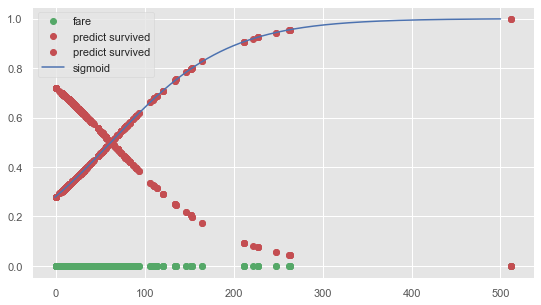

In [333]:
plt.figure(figsize=(9, 5))

plt.plot(fare, np.zeros(len(fare)), 'o', color='g', label='fare')
plt.plot(fare, proba, 'o', color='r', label='predict survived')
plt.plot(x_range, sigmoid(x_range), '-', color='b', label='sigmoid')
plt.legend(loc=2)
plt.show()

上のグラフから判断できること：
* 運賃は0～260くらいで、一人だけ500を超えている。
* 生存確率は y=0.5 に対して反転している。
* 運賃が約60を超えた乗客は、生存率が0.5を超える。

## 1. ロジスティック回帰
### 実装(2変数から生死を判別)
Pclass_GenderとAgeを説明変数とする。 <br/>
Pclass_Genderは、PclassにGender(Sexがfemale:0, male:1)を加えた新規列。

In [334]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [335]:
sex = train_df['Sex'].copy()

In [336]:
sex = sex.apply(lambda x: 0 if x == 'female' else 1)

In [337]:
train_df['Sex'] = sex

In [338]:
train_df['Sex'].value_counts()

1    577
0    314
Name: Sex, dtype: int64

In [339]:
train_df['Pclass_Gender'] = train_df['Pclass'] + train_df['Sex']

In [340]:
train_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_Gender
0,0,3,1,22.0,1,0,7.2500,S,4
1,1,1,0,38.0,1,0,71.2833,C,1
2,1,3,0,26.0,0,0,7.9250,S,3


In [341]:
train_df = train_df.drop(['Pclass', 'Sex'], axis=1)

In [342]:
train_df.head(1)

,Survived,Age,SibSp,Parch,Fare,Embarked,Pclass_Gender
0,0,22.0,1,0,7.25,S,4


In [343]:
# 生存者のインデックスリスト
index_survived = train_df[train_df["Survived"]==1].index
# 非生存者のインデックスリスト
index_notsurvived = train_df[train_df["Survived"]==0].index

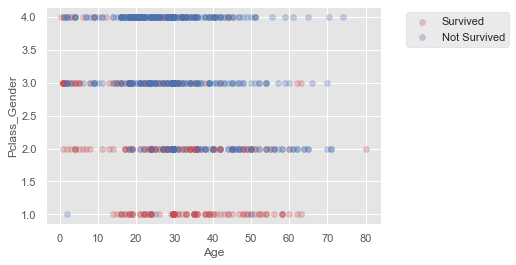

In [344]:
fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# 生存者の散布図
sc = ax.scatter(train_df.loc[index_survived, 'Age'],
                train_df.loc[index_survived, 'Pclass_Gender'],
                color='r', label='Survived', alpha=0.3)
# 非生存者の散布図
sc = ax.scatter(train_df.loc[index_notsurvived, 'Age'],
                train_df.loc[index_notsurvived, 'Pclass_Gender'],
                color='b', label='Not Survived', alpha=0.3)

ax.set_xlabel('Age')
ax.set_ylabel('Pclass_Gender')
ax.legend(bbox_to_anchor=(1.4, 1.))
plt.show()

In [345]:
data2 = train_df[['Age', 'Pclass_Gender']].copy()

In [346]:
target2 = train_df['Survived']

In [347]:
print(data2.shape)
print(target2.shape)

(891, 2)
(891,)


In [348]:
model2 = LogisticRegression()

In [349]:
model2.fit(data2, target2)  # モデルを学習させる

LogisticRegression()

In [350]:
model2.predict([[10,1]])  # Age: 10, Pclass_Gender: 1 の乗客を予測

array([1], dtype=int64)

In [351]:
model2.predict_proba([[10,1]])  # 生存確率を表示 [非生存率, 生存率]

array([[0.03754749, 0.96245251]])

#### Colormapにロジスティック回帰の結果を重ねて描画する

In [352]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

In [353]:
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = model2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

In [379]:
print(Z.shape)

(200, 4500)


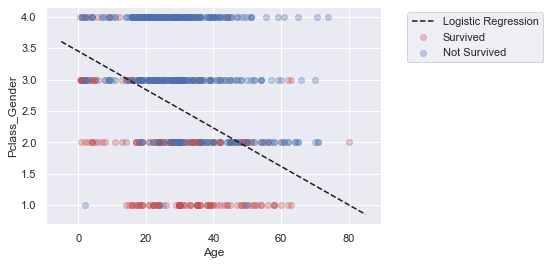

In [378]:
fig, ax = plt.subplots()
levels = np.linspace(0, 1.0)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# 生存者の分布
sc = ax.scatter(train_df.loc[index_survived, 'Age'],
                train_df.loc[index_survived, 'Pclass_Gender'],
                color='r', label='Survived', alpha=0.3)
# 非生存者の分布
sc = ax.scatter(train_df.loc[index_notsurvived, 'Age'],
                train_df.loc[index_notsurvived, 'Pclass_Gender'],
                color='b', label='Not Survived', alpha=0.3)
# ロジスティック回帰の結果
x1 = xmin
x2 = xmax
y1 = -1 * (model2.intercept_[0] + model2.coef_[0][0] * xmin) / model2.coef_[0][1]
y2 = -1 * (model2.intercept_[0] + model2.coef_[0][0] * xmax) / model2.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--', label='Logistic Regression')

ax.set_xlabel('Age')
ax.set_ylabel('Pclass_Gender')
ax.legend(bbox_to_anchor=(1.5, 1.))
plt.show()

## 2. モデル評価
混同行列とクロスバリデーション

### 1変数データ(運賃)のモデル評価

In [357]:
# 学習用、テスト用で分割する
train1_data, test1_data, train1_label, test1_label = train_test_split(fare, survived1, test_size=0.2) 

In [358]:
eval_model1 = LogisticRegression()

In [359]:
eval_model1.fit(train1_data, train1_label)

LogisticRegression()

In [360]:
pred1 = eval_model1.predict(test1_data)

In [361]:
train1_score = eval_model1.score(train1_data, train1_label)
print(f'1変数学習データの決定係数: {train1_score}')

1変数学習データの決定係数: 0.6769662921348315


In [362]:
test1_score = eval_model1.score(test1_data, test1_label)
print(f'1変数テストデータの決定係数: {test1_score}')

1変数テストデータの決定係数: 0.6256983240223464


In [363]:
# 適合率、再現率、F値などを表示
print(metrics.classification_report(test1_label, pred1))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75       105
           1       0.68      0.18      0.28        74

    accuracy                           0.63       179
   macro avg       0.65      0.56      0.51       179
weighted avg       0.65      0.63      0.55       179



In [364]:
# 混同行列を表示
confusion_mat1 = confusion_matrix(test1_label, pred1)
print(confusion_mat1)

[[99  6]
 [61 13]]


### 2変数データ(Age, Pclass_Gender)のモデル評価

In [365]:
# 学習用、テスト用で分割する
train2_data, test2_data, train2_label, test2_label = train_test_split(data2, target2, test_size=0.2) 

In [366]:
eval_model2 = LogisticRegression()

In [367]:
eval_model2.fit(train2_data, train2_label)

LogisticRegression()

In [368]:
pred2 = eval_model2.predict(test2_data)

In [369]:
train2_score = eval_model2.score(train2_data, train2_label)
print(f'2変数学習データの決定係数: {train2_score}')

2変数学習データの決定係数: 0.776685393258427


In [370]:
test2_score = eval_model2.score(test2_data, test2_label)
print(f'2変数テストデータの決定係数: {test2_score}')

2変数テストデータの決定係数: 0.7541899441340782


In [371]:
# 適合率、再現率、F値などを表示
print(metrics.classification_report(test2_label, pred2))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       111
           1       0.71      0.60      0.65        68

    accuracy                           0.75       179
   macro avg       0.74      0.72      0.73       179
weighted avg       0.75      0.75      0.75       179



In [372]:
# 混同行列を表示
confusion_mat2 = confusion_matrix(test2_label, pred2)
print(confusion_mat2)

[[94 17]
 [27 41]]


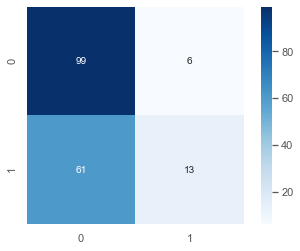

In [373]:
# 混同行列1のヒートマップを描画
sns.heatmap(confusion_mat1, vmin=None, vmax=None, cmap="Blues",
                   center=None, robust=False, annot=True, fmt='.2g', annot_kws=None,
                   linewidths=0, linecolor='white', square=True, ax=None,  mask=None,
                   cbar=True, cbar_kws=None, cbar_ax=None)
plt.show()

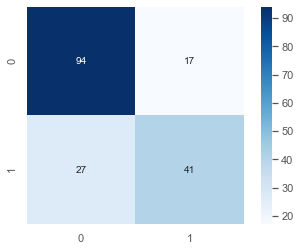

In [374]:
# 混同行列2のヒートマップを描画
sns.heatmap(confusion_mat2, vmin=None, vmax=None, cmap="Blues",
                   center=None, robust=False, annot=True, fmt='.2g', annot_kws=None,
                   linewidths=0, linecolor='white', square=True, ax=None,  mask=None,
                   cbar=True, cbar_kws=None, cbar_ax=None)
plt.show()

In [375]:
# seabornで扱えるようなTitanicデータを読み込む
titanic_data = sns.load_dataset('titanic')

e:\venv\datascience\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


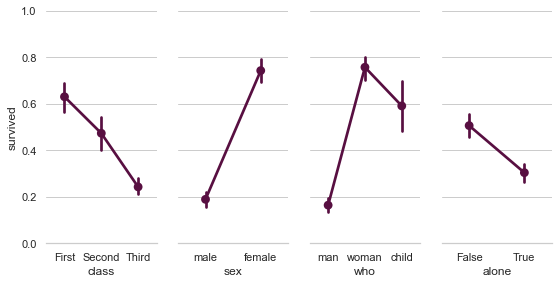

In [376]:
sns.set(style='whitegrid')

# 各変数ごとに、生存か非生存かの割合を描画
grid = sns.PairGrid(titanic_data, y_vars='survived',
                            x_vars=['class', 'sex', 'who', 'alone'], size=4, aspect=.5)
grid.map(sns.pointplot, color=sns.xkcd_rgb['plum'])
grid.set(ylim=(0, 1))
sns.despine(fig=grid.fig, left=True)
plt.show()

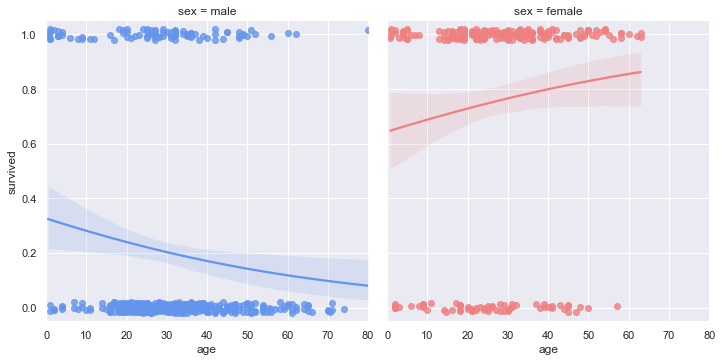

In [377]:
sns.set(style="darkgrid")

# 性別ごとに色を設定する
palette = dict(male="#6495ED", female="#F08080")

# 男性、女性別で年齢による生存率を描画
# ※ pip install statsmodels をインストールしないとModuleNotFoundErrorになった
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex",
                      data=titanic_data, palette=palette, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))
plt.show()